## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import argparse
from scipy import interpolate
import tqdm
import nmmn.lsd, nmmn.misc
import os.path
import pandas as pd
import astropy.visualization

In [3]:
# Constants, definitions and units

# many are related to grmonty, but we can set a black hole mass if we want to have a "feeling" for the physical values

global MP, ME, CL, GNEWT, KBOL, SIGMA_THOMSON, MSUN, LSUN, YEAR, MBH
global TPTE_DISK, TPTE_JET, THETAE_MAX
global M_unit, L_unit, T_unit, RHO_unit, U_unit, B_unit, Ne_unit

# all constants in cgs units
ME = 9.1093826e-28 # electron mass
MP = 1.67262171e-24 # proton mass
CL = 2.99792458e10 # speed of light
GNEWT = 6.6742e-8 # gravitational constant
KBOL = 1.3806505e-16 # Boltzmann constant
SIGMA_THOMSON = 0.665245873e-24 # Thomson cross-section
MSUN = 1.989e33 # solar mass
LSUN = 3.827e33 # solar luminosity
YEAR = 31536000 # seconds in a year

# temperature and beta-prescription (Mościbrodzka 2016)
TPTE_DISK = 20. # R_high
TPTE_JET = 1. # R_low
THETAE_MAX = 1000.
TP_OVER_TE = 100.0

# grmonty units and BH mass
MBH = 4.5e6 * MSUN # Sgr A*
#MBH = 6.2e9 * MSUN # M87
#MBH = 5.0e9 * MSUN
#MBH = 10.0 * MSUN
M_unit = 1.0e19
#M_unit = 2.0*10e11
L_unit = GNEWT * MBH / (CL * CL)
T_unit = L_unit / CL
RHO_unit = M_unit / (L_unit*L_unit*L_unit)
U_unit = RHO_unit * CL * CL
B_unit = CL * np.sqrt(4. * np.pi * RHO_unit)
Ne_unit = RHO_unit / (MP + ME)

## Read dump files

In [4]:
%run -i harm_script2.py
#rg("gdump")
rd("dump400")

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


In [5]:
N1, N2, N3 = nx, ny, nz

sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)

betapl = 2.0*pg/bsq

bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = sqrt(Jsq)

EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)

enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.0)

harm_script2.py:6: RuntimeWarning: divide by zero encountered in true_divide
  import argparse
harm_script2.py:6: RuntimeWarning: overflow encountered in true_divide
  import argparse


In [6]:
Jfile = "/home/gustavo/work/gyst/jcs_files/dump400_jcs"
Jfilepeak = "/home/gustavo/work/gyst/jcs_files/dump400_jcs_peak"
Jfilechar = "/home/gustavo/work/gyst/jcs_files/dump400_jcs_char"

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

f2 = open(Jfilepeak, "rb")
dtype = np.float64
body = np.fromfile(f2,dtype=dtype,count=-1)
JJ_cs_peak = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

JJ_cs_char_ind = numpy.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1
                
#Jdata = np.loadtxt(Jfile)
#JJ_cs = np.reshape(Jdata, (int(N1), int(N2), int(N3)))

rx = []
ry = []
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))

## Make a few test plots

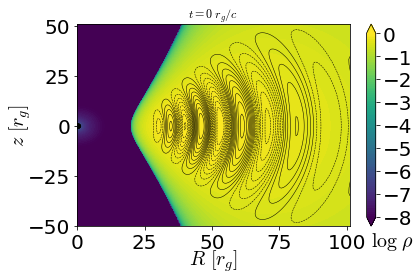

In [170]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25





hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(rho),levels = np.linspace(-8, 0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\rho$",fontsize=20,ha="left")
cb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho.png", dpi = 300)

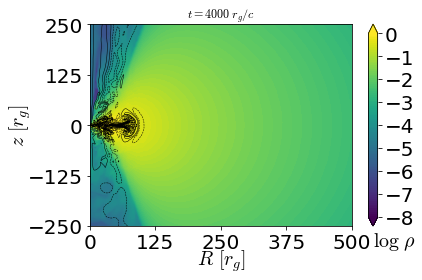

In [44]:
mirror = 1
if(mirror):
    xmax = 500
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 100
    ymax = 0
    xmin = 0
    ymin = -xmax
    step = 25

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(rho),levels = np.linspace(-8, 0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\rho$",fontsize=20,ha="left")
cb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
plc(aphi,levels=np.linspace(-amax,amax,10)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho_large.png", dpi = 300)

harm_script2.py:8: RuntimeWarning: divide by zero encountered in log10
  from matplotlib import rc
harm_script2.py:8: RuntimeWarning: invalid value encountered in log10
  from matplotlib import rc


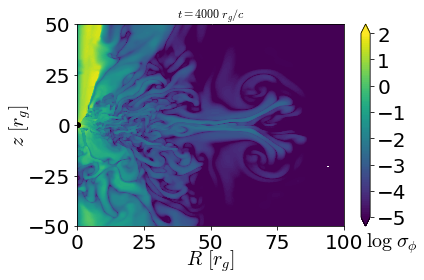

In [19]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(sigmaphi),levels = np.linspace(-5, 2, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\sigma_\phi$",fontsize=20,ha="left")
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("sigmaphi.png", dpi = 300)

harm_script2.py:8: RuntimeWarning: divide by zero encountered in log10
  from matplotlib import rc


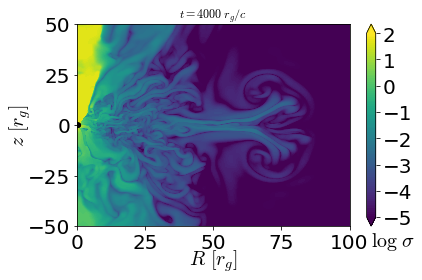

In [161]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(sigma),levels = np.linspace(-5, 2, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\sigma$",fontsize=20,ha="left")
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("sigma.png", dpi = 300)

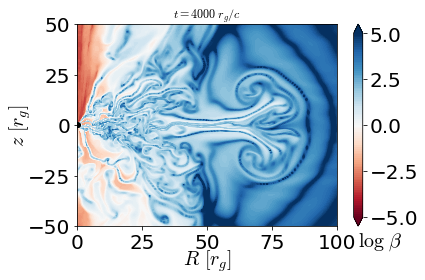

In [20]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(betapl), levels = np.linspace(-5, 5, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\beta$",fontsize=20,ha="left")
cb.set_ticks([-5,-2.5,0,2.5,5])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("beta.png", dpi = 300)

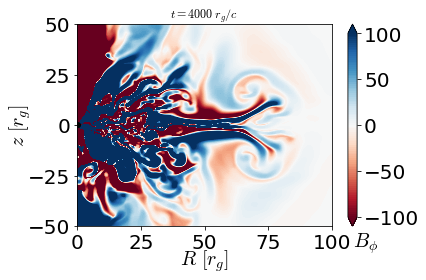

In [27]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(Bphi*B_unit, levels = np.linspace(-100, 100, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
cb.set_ticks([-100,-50,0,50,100])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("Bphi.png", dpi = 300)

In [ ]:
xmax = 80
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(va, levels = np.linspace(0, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$v_A$",fontsize=20,ha="left")
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

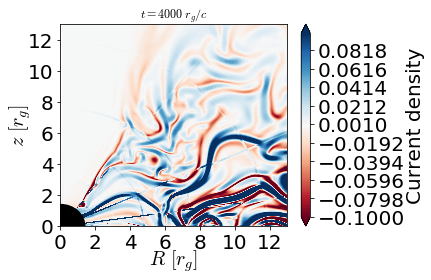

In [19]:
mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmax = 12
    ymax = 12
    xmin = 0
    ymin = 0
    step = 2


#cs, cb = plco(jcurr/jcurr.max(), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(jd[3], levels=np.linspace(-10e-2,10e-2,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.01])
#cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_4000.png", format = "png", dpi = 300)
#plt.clf

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


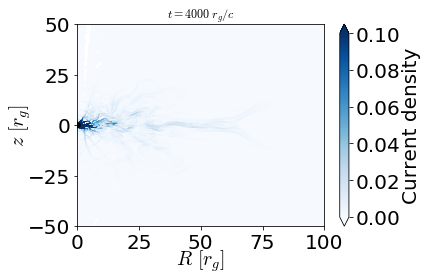

In [28]:
xmax = 100
ymax = xmax/2
step = xmax/4

#cs, cb = plco(jcurr/jcurr.max(), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(jcurr, levels=np.linspace(0,10e-2,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
#cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, xmax+1, step = step))
plt.yticks(np.arange(-ymax, ymax+1, step = step))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_4000.png", format = "png", dpi = 300)
#plt.clf

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


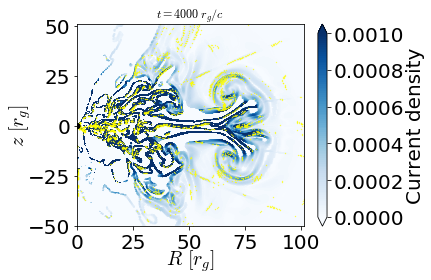

In [7]:
mirror = 1
if(mirror):
    xmax = 100
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(JJ_cs, levels=np.linspace(0,10e-4,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-5,0,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)

#plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

#cb.ax.set_xlabel(r"$\log\;J$",fontsize=20,ha="left")
#cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')
fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_sites.png", format = "png", dpi = 300)
#plt.clf

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


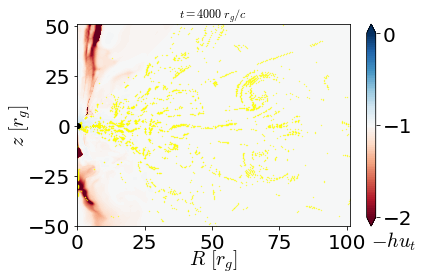

In [8]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25





hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(unb,levels = np.linspace(-2,0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$-hu_t$",fontsize=20,ha="left")
cb.set_ticks([-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("bernoulli.png", dpi = 300)

In [ ]:
xmax = 20
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(Bphi, levels = np.linspace(-2., 2., 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
cb.set_ticks([-2.0,-1.,0,1.,2.0])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

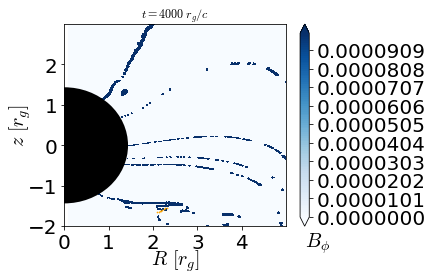

In [17]:
icord = [408,409,411,413,415,416,418,419]
jcord = [113,112,111,110,110,109,109,107]

rxx = []
ryy = []

for i in range(len(icord)):
    rxx.append(r[jcord[i]][icord[i]][0] * np.sin(h[jcord[i]][icord[i]][0]))
    ryy.append(r[jcord[i]][icord[i]][0] * np.cos(h[jcord[i]][icord[i]][0]))
    
#testi = [333, 350, 361, 389, 791]
#testj = [57, 146, 103, 199, 477]
testi = [109]
testj= [58]
testx = []
testy = []
for i in range(len(testi)):
    testx.append(r[testi[i]][testj[i]][0] * np.sin(h[testi[i]][testj[i]][0]))
    testy.append(r[testi[i]][testj[i]][0] * np.cos(h[testi[i]][testj[i]][0]))


mirror = 1
if(mirror):
    xmax = 4
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmax = 5
    ymax = -10
    xmin = 0
    ymin = -15
    step = 5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

#cs, cb = plco(Bphi, levels = np.linspace(-1, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 0.5)#, markersize = 0.01)
#plt.scatter(testx, testy, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

In [40]:
np.count_nonzero(JJ_cs)

67184

In [41]:
np.count_nonzero(JJ_cs_peak)

29547

In [42]:
np.count_nonzero(JJ_cs_char)

5515

## Characterization of current sheets

In [ ]:
hdeg = degrees(h[0])
hfont = {'fontname':'Helvetica'}
plt.plot(hdeg,sigma[55], label = r'$r = 5\;r_g$', color = 'black')
plt.plot(hdeg,sigma[83], label = r'$r = 10\;r_g$', color='green')
plt.plot(hdeg,sigma[99], label = r'$r = 15\;r_g$', color ='blue')
plt.plot(hdeg,sigma[110], label = r'$r = 20\;r_g$', color='yellow')
plt.yscale('log')
plt.xlabel(r'$\theta\;(deg)$')
plt.ylabel(r'$\sigma$')
plt.xticks(np.arange(0, 181, step=30)) #GS
#plt.yticks(np.arange(49, 50, step=10)) #GS
plt.legend()
plt.tight_layout() # GS
#plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/sigma_radius.png", dpi = 200)


### Regrid

In [ ]:
def regrid(radius, angle, bu3, jcurr, JJ_cs, n1, n2, xlim = None):
 
    """
        bu3: b_phi
        jcurr: current
        JJ_cs: only current sheet
    
    """
    
    if(xlim == None):
        xlim = radius.max()
    
    n1new = 3000
    n2new = 3000
    
    angle = -(angle-numpy.pi/2.) # spherical angle => polar angle

    xnew = numpy.linspace(0, xlim, n1new)
    ynew = numpy.linspace(-xlim, xlim, n2new)
    
    #new_rg_x = xnew*xlim/n1new
    #new_rg_y = new_rg_x - 0.5*n2new

    new_bu3   = numpy.zeros((n1new, n2new))
    new_jcurr = numpy.zeros((n1new, n2new))
    new_JJcs  = numpy.zeros((n1new, n2new))

    # *****BOTTLENECK*****
    # goes through new array
    for i in range(xnew.size):
        for j in range(ynew.size):
                    
            rnew, thnew = nmmn.misc.cart2pol(xnew[i], ynew[j])
            # position in old array
            iref = nmmn.lsd.search(rnew, radius)
            jref = nmmn.lsd.search(thnew, angle)

            new_bu3[j,i]   = bu3[iref,jref]
            new_jcurr[j,i] = jcurr[iref,jref]
            new_JJcs[j,i]  = JJ_cs[iref,jref]
    # *****END BOTTLENECK*****
        
    return new_bu3, new_jcurr, new_JJcs, n1new, n2new, xnew, ynew

In [ ]:
c_bu3 = bu[3][:,:,0]
c_jcurr = jcurr[:,:,0]
c_JJcs = JJ_cs[:,:,0]
c_r = r[:,0,0]#.flatten()
c_h = h[0,:,0]#.flatten()

In [ ]:
r0 = 1.1951147
r1 = 1.2411376
deltar = r1 - r0
print(deltar)
print(100/deltar)

In [ ]:
%%time
n_bu3, n_jcurr, n_JJcs, nx_new, ny_new, rgx, rgy = regrid (c_r, c_h, c_bu3, c_jcurr, c_JJcs, nx, ny, xlim=80)

In [ ]:
def withinlimits(icell, jcell):
    
    if (icell >= nx_new): icell = nx_new-1
    elif (icell < 0): icell = 0
    if (jcell >= ny_new): jcell = ny_new-1
    elif (jcell < 0): jcell = 0
        
    return icell, jcell

In [ ]:
def alongplus(i, j, mat, slope, intercept, dist_increase, thr):

    global ip, jp, bp, bp_arr, jcurrp, jp_arr, xp, yp

    bp_arr = []
    jp_arr = []
    dist = 0
    k = 0

    while True:
        ip = i + dist
        jp = slope*ip + intercept
        
        if (ip < 0 or jp < 0):
            break
                
        # round cells
        ip = int(round(ip))
        jp = int(round(jp))
    
        # make sure the cells are within grid limits
        ip, jp = withinlimits(ip, jp)
                    
        # get physical quantities
        bp = mat[ip][jp]
        jcurrp = n_jcurr[ip][jp]
                
        if (dist > thr):
            #xp = ip
            #yp = jp
            break
                                
        # append quantities to arrays
        bp_arr.append(bp)
        jp_arr.append(jcurrp)
        
        # get current "last" member of sequence coordinates and increase distance
        xp = ip#r[ip][jp] * np.sin(h[ip][jp])
        yp = jp#r[ip][jp] * np.cos(h[ip][jp])
        dist += dist_increase
        
def alongminus(i, j, mat, slope, intercept, dist_increase, thr):

    global im, jm, bm, bm_arr, jcurr, jm_arr, xm, ym

    bm_arr = []
    jm_arr = []
    dist = 0
    k = 0

    while True:       
        im = i - dist
        jm = slope*im + intercept
        
        if (im < 0 or jm < 0):
            break
                
        # round cells
        im = int(round(im))
        jm = int(round(jm))
    
        # make sure the cells are within grid limits
        im, jm = withinlimits(im, jm)
                    
        # get physical quantities
        bm = mat[im][jm]
        jcurrm = n_jcurr[im][jm]
                
        if (dist > thr):
            #xm = im
            #ym = jm
            break
                                
        # append quantities to arrays
        bm_arr.append(bm)
        jm_arr.append(jcurrm)

        # get current "last" member of sequence coordinates and increase distance
        xm = im#r[im][jm] * np.sin(h[im][jm])
        ym = jm#r[im][jm] * np.cos(h[im][jm])
        dist += dist_increase
                
def get_intercept(x, y, slope):
    return y - slope * x

In [ ]:
BOXSIZE = 25#11
LIMIT = int(BOXSIZE/2 - 0.5)
Bu3_THR = 10e-2
dist_increase = 0.2
thr = 5
n_bphi = n_bu3*B_unit

In [ ]:
#print(n_JJcs[n_JJcs != 0])
#print(JJ_cs[JJ_cs != 0])
#np.where(n_JJcs != 0)
#np.where(np.abs(n_bphi) < Bu3_THR)

### All points

In [ ]:
k = 0

#for i in range(LIMIT, nx_new-LIMIT, 1):
#for i in range(1498, nx_new-LIMIT, 1):
for i in range(1600, 1800, 1):
    #for j in range(LIMIT, ny_new-LIMIT, 1):
    for j in range(LIMIT, 290-LIMIT, 1):

        xc = i#r[i][j] * np.sin(h[i][j])
        yc = j#r[i][j] * np.cos(h[i][j])

        if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
            # get box limits
            ibox_min = i - LIMIT
            jbox_min = j - LIMIT
            ibox_max = i + LIMIT
            jbox_max = j + LIMIT
            
            # check within box
            nbox = 0
            theta = 0
            for ibox in range(ibox_min, ibox_max+1, 1):
                for jbox in range(jbox_min, jbox_max+1, 1):
                    
                    # make sure we are not applying this to our central point (i,j)
                    if ((i == ibox) and (j == jbox)):
                        continue
                    
                    # check if point belongs to sheet
                    elif((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
                        # get angle
                        nbox += 1
                        if (i == ibox):
                            theta += 0
                        else:
                            theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
            # once we finish the box, we get the average slope
            theta = theta/nbox
            slope = np.tan(theta)
            normal = -1./slope
            intercept = get_intercept(i, j, normal)

            alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
            alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

            print("xm,ym,xp,yp,slope,intercept")
            print(xm,ym,xp,yp,slope,intercept)
            
            bp_arr = np.asarray(bp_arr)
            bm_arr = np.asarray(bm_arr)
            jp_arr = np.asarray(jp_arr)
            jm_arr = np.asarray(jm_arr)

            # flip m array so we can have a continuous array with p and m quantities
            bm_arr = np.flip(bm_arr, 0)
            jm_arr = np.flip(jm_arr, 0)
            bplot = np.append(bm_arr, bp_arr)
            jplot = np.append(jm_arr, jp_arr)

            # normalize jplot
            jplot = jplot/np.max(jplot)

            plt.figure(num=1, figsize=(6,4))

            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            #rcParams['font.size'] = 8

            myvar = n_bu3*B_unit
            plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
            ax = plt.gca()
            ax.set_aspect(1)
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            plt.xticks(np.arange(0, 21, step=5))
            plt.yticks(np.arange(-10, 11, step=5))
            plt.xlim(0,20)
            plt.ylim(-10,10)
            fig = plt.gcf()
            plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
            plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
            cbar = plt.colorbar()
            cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
            #generate ellipse object
            #import the Ellipse function
            from matplotlib.patches import Ellipse
            #create Ellipse "actor"
            el = Ellipse((0,0), #origin of ellipse
                2*rhor, 2*rhor, #major axes of ellipse
                facecolor='black', #color of ellipse
                alpha=1) #opacity of ellipse
            ax=plt.gca() #get current axes
            art=ax.add_artist(el) #show object in axes
            art.set_zorder(20) #bring ellipse to front
            plt.tight_layout()  # otherwise the right y-label is slightly clipped

            ax1 = fig.add_axes([0.475, 0.295, 0.23, 0.23])
            ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
            color = 'xkcd:dark purple'
            ax1.set_xlabel('dist (arbitrary units)', fontsize = 8)
            ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
            ax1.plot(bplot, color=color)
            ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
            ax1.tick_params(axis='x', labelsize = 8)
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'xkcd:dark orange'
            ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
            ax2.plot(jplot, color=color)
            ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
            plt.tight_layout()  # otherwise the right y-label is slightly clipped
            
            plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/%d_%d_%d.png" %(j, i, k), dpi = 250)
            plt.close()

### Single point

In [ ]:
#i = 1498
#j = 56

i = 1554
j = 41

k = 0

xc = i#r[i][j] * np.sin(h[i][j])
yc = j#r[i][j] * np.cos(h[i][j])


if((n_JJcs[i][j] != 0) and (np.abs(n_bu3[i][j]) < Bu3_THR)):
    # get box limits
    ibox_min = i - LIMIT
    jbox_min = j - LIMIT
    ibox_max = i + LIMIT
    jbox_max = j + LIMIT
            
    # check within box
    nbox = 0
    theta = 0
    for ibox in range(ibox_min, ibox_max+1, 1):
        for jbox in range(jbox_min, jbox_max+1, 1):
                    
            # make sure we are not applying this to our central point (i,j)
            if ((i == ibox) and (j == jbox)):
                continue
                    
            # check if point belongs to sheet
            if((n_JJcs[i][j] != 0) and (np.abs(n_bu3[i][j]) < Bu3_THR)):       
                # get angle
                nbox += 1
                if (i == ibox):
                    theta += 0
                else:
                    theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
    # once we finish the box, we get the average slope
    theta = theta/nbox
    slope = np.tan(theta)
    slope = 0.575
    normal = -1./slope
    intercept = get_intercept(i, j, normal)

    alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
    alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

    bp_arr = np.asarray(bp_arr)
    bm_arr = np.asarray(bm_arr)
    jp_arr = np.asarray(jp_arr)
    jm_arr = np.asarray(jm_arr)

    # flip m array so we can have a continuous array with p and m quantities
    bm_arr = np.flip(bm_arr, 0)
    jm_arr = np.flip(jm_arr, 0)
    bplot = np.append(bm_arr, bp_arr)
    jplot = np.append(jm_arr, jp_arr)

    # normalize jplot
    jplot = jplot/np.max(jplot)

    # plot snapshots

    plt.figure(num=1, figsize=(6,4))

    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    #rcParams['font.size'] = 8

    myvar = n_bu3*B_unit
    plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    plt.xticks(np.arange(0, 21, step=5))
    plt.yticks(np.arange(-10, 11, step=5))
    plt.xlim(0,20)
    plt.ylim(-10,10)
    fig = plt.gcf()
    plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
    plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
    cbar = plt.colorbar()
    cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
    #generate ellipse object
    #import the Ellipse function
    from matplotlib.patches import Ellipse
    #create Ellipse "actor"
    el = Ellipse((0,0), #origin of ellipse
        2*rhor, 2*rhor, #major axes of ellipse
        facecolor='black', #color of ellipse
        alpha=1) #opacity of ellipse
    ax=plt.gca() #get current axes
    art=ax.add_artist(el) #show object in axes
    art.set_zorder(20) #bring ellipse to front
    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    
    from matplotlib.ticker import FormatStrFormatter
    
    ax1 = fig.add_axes([0.43, 0.5, 0.25, 0.25])
    ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
    color = 'xkcd:green'
    ax1.set_xlabel(r'$\mathrm{distance}\;(r_g)$', fontsize = 8, color = 'yellow')
    sizeline = np.sqrt((rgx[ym] - rgx[yp])**2 + (rgy[xm] - rgy[xp])**2)
    my_xticks = [0.00,0.17,0.34,0.51,0.68]
    ax1.xaxis.set_major_formatter(ticker.FixedFormatter(my_xticks))
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
    ax1.plot(bplot, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
    ax1.tick_params(axis='x', labelsize = 8, color = 'yellow')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'xkcd:dark orange'
    ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
    ax2.plot(jplot, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
    plt.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/%d_%d_%d.png" %(j, i, k), dpi = 200)
    plt.close()

In [ ]:
rgx[yc]

In [ ]:
rgy[xc]

In [ ]:
rrrr = np.sqrt(rgx[yc]**2 + rgy[xc]**2)
thth = np.arctan(rgy[xc]/rgx[yc])

In [ ]:
rrrr 3.10800934e+00

In [ ]:
thth 1.2146679

In [ ]:
r[36,0,0]

In [ ]:
h[0,49,0]

In [ ]:
bplot

In [ ]:
np.sqrt((rgx[ym] - rgx[yp])**2 + (rgy[xm] - rgy[xp])**2)

In [ ]:
rgx[ym]

In [ ]:
rgx[yp]

In [ ]:
rgy[xm]

In [ ]:
rgy[xp]

In [ ]:
rgx[41]

In [ ]:
rgy[1554]

In [ ]:
bb1 = bplot/np.max(bplot)

In [ ]:
bb2 = bplot/np.max(bplot)

In [ ]:
bb3 = bplot/np.max(bplot)

In [ ]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
plt.title(r'$b_\phi$ profiles at current sheets: normalized sample')
plt.xlabel('dist (arbitrary units)', fontsize = 12)
plt.ylabel(r'$b_\phi\;(G)$')
plt.plot(bb1, color = 'red')
plt.plot(bb2, color = 'blue')
plt.plot(bb3, color = 'green')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("/home/gustavo/profiles/many_bs.png", dpi = 200)
plt.close()

### Plot only

In [ ]:
# plot snapshots

plt.figure(num=1, figsize=(6,4))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
#rcParams['font.size'] = 8

myvar = n_bu3*B_unit
plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
plt.xticks(np.arange(0, 21, step=5))
plt.yticks(np.arange(-10, 11, step=5))
plt.xlim(0,20)
plt.ylim(-10,10)
fig = plt.gcf()
plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='xkcd:teal', linestyle='-', linewidth=0.5)
plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
#generate ellipse object
#import the Ellipse function
from matplotlib.patches import Ellipse
#create Ellipse "actor"
el = Ellipse((0,0), #origin of ellipse
    2*rhor, 2*rhor, #major axes of ellipse
    facecolor='black', #color of ellipse
    alpha=1) #opacity of ellipse
ax=plt.gca() #get current axes
art=ax.add_artist(el) #show object in axes
art.set_zorder(20) #bring ellipse to front
plt.tight_layout()  # otherwise the right y-label is slightly clipped

ax1 = fig.add_axes([0.475, 0.295, 0.23, 0.23])
ax1.set_title(r'$b_\phi$ and current profiles', fontsize = 8)
color = 'xkcd:dark purple'
ax1.set_xlabel('dist (arbitrary units)', fontsize = 8)
ax1.set_ylabel(r'$b_\phi\;(G)$', color=color, fontsize = 8)
ax1.plot(bplot, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize = 8)
ax1.tick_params(axis='x', labelsize = 8)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'xkcd:dark orange'
ax2.set_ylabel('Current density', color=color, fontsize = 8)  # we already handled the x-label with ax1
ax2.plot(jplot, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize = 8)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
"""
# plot profiles
ax1 = plt.subplot(122)
color = 'tab:blue'
ax1.set_xlabel('dist')
ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
ax1.plot(bplot, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
ax2.plot(jplot, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()  # otherwise the right y-label is slightly clipped
"""
plt.savefig("/home/gustavo/profiles/doubleplot_%d_%d_%d.png" %(j, i, k), dpi = 250)
plt.close()

## Current sheets

In [ ]:
#Jfile = "/work/gustavo/2ds9/harmpi-master/current_sheets/dump065_jcs"
#Jfile = "/work/gustavo/2ds9/harmpi-master/current_sheets/dump065_jcs_peak"
Jfile = "/home/gustavo/Dropbox/trabalho/career/current_sheets/dump065_jcs"

Jdata = np.loadtxt(Jfile)
JJ_cs = np.reshape(Jdata, (int(N1), int(N2), int(N3)))

In [ ]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(Bphi, levels=np.linspace(-50,50), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap='RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
cb.ax.set_xlabel(r"$B_\phi(G)$",fontsize=20,ha="left")
cb.set_ticks([-50,-25,0,25,50])
plt.xticks(np.arange(0, 21, step = 5))
plt.yticks(np.arange(-10, 11, step = 5))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)
#plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
#plot([rgx[ym]-0.35, rgx[yp]-0.35], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
plt.savefig("Bphi_t0650.png", format = "png", dpi = 300)
#plt.clf

In [ ]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(JJ_cs, levels=np.linspace(0,10e-2,100), ticks=[0, 0.05, 0.1], isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, 21, step = 5))
plt.yticks(np.arange(-10, 11, step = 5))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
plt.savefig("sheets_t0650.png", format = "png", dpi = 300)
#plt.clf

In [ ]:
JJ_cs2 = JJ_cs
JJ_cs2[JJ_cs2 > 0] = 1

In [ ]:
JJ_cs2.shape

In [ ]:
r[:,0,0]

In [ ]:
#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs = plco(JJJ, levels=np.linspace(0,0.1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=10, dobh=1, cb=0, extend = "both", pretty=1, cmap = 'Blues')
plt.contourf(JJ_cs2[:,:,0], color ='yellow')
#cs2 = plco(JJ_cs2, color='yellow')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, 11, step = 2))
plt.yticks(np.arange(0, 11, step = 2))
plt.xlim(0,10)
plt.ylim(0,10)
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("current.png", format = "png", dpi = 300)
#plt.clf

## SANDBOX

Plotting, old way

In [ ]:
    
    """
    # plot profiles
    fig, ax1 = plt.subplots()
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    color = 'tab:blue'
    ax1.set_xlabel('dist')
    ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
    ax1.plot(bplot, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
    ax2.plot(jplot, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig("/home/gustavo/profiles/prof/%d_%d_%d.png" %(j, i, k), dpi = 200)
    plt.close()
    
    # plot snapshots
    myvar = n_bu3*B_unit
    plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    plt.xticks(np.arange(0, 21, step=5))
    plt.yticks(np.arange(-10, 11, step=5))
    plt.xlim(0,20)
    plt.ylim(-10,10)
    fig = plt.gcf()
    plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
    plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
    cbar = plt.colorbar()
    cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
    #generate ellipse object
    #import the Ellipse function
    from matplotlib.patches import Ellipse
    #create Ellipse "actor"
    el = Ellipse((0,0), #origin of ellipse
        2*rhor, 2*rhor, #major axes of ellipse
        facecolor='black', #color of ellipse
        alpha=1) #opacity of ellipse
    ax=plt.gca() #get current axes
    art=ax.add_artist(el) #show object in axes
    art.set_zorder(20) #bring ellipse to front
    plt.draw() #make sure it's drawn
    fig.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(j, i, k), dpi = 250)
    plt.close()
"""
    #plt.imshow(n_bu3*B_unit)
    #plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    #plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
    #plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    #plt.close()
    """
    cs, cb = plco(n_bu3*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
    plt.xticks(np.arange(0, 21, step=2))
    fig = plt.gcf()
    plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
    #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
    #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
    plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
    plt.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    plt.close()  
    """
    #plt.imshow(n_bu3, origin='lower', cmap='RdBu', vmin=-0.02, vmax=0.02)
    #plt.imshow(myvar, origin='lower', cmap='RdBu', vmin=-25.0, vmax=25.0, extent=[-myvar.shape[1]/2., myvar.shape[1]/2., -myvar.shape[0]/2., myvar.shape[0]/2.])
    #plt.imshow(myvar, origin='lower', cmap='RdBu', vmin=-25.0, vmax=25.0, interpolation = 'none', extent=[0,myvar.shape[1], -myvar.shape[0]/2., myvar.shape[0]/2.])

In [ ]:
"""   
k = 0

#for i in range(LIMIT, nx_new-LIMIT, 1):
#for i in range(1498, nx_new-LIMIT, 1):
for i in range(1487, 1493, 1):
    #for j in range(LIMIT, ny_new-LIMIT, 1):
    for j in range(LIMIT, 290-LIMIT, 1):

        xc = i#r[i][j] * np.sin(h[i][j])
        yc = j#r[i][j] * np.cos(h[i][j])

        if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
            # get box limits
            ibox_min = i - LIMIT
            jbox_min = j - LIMIT
            ibox_max = i + LIMIT
            jbox_max = j + LIMIT
            
            # check within box
            nbox = 0
            theta = 0
            for ibox in range(ibox_min, ibox_max+1, 1):
                for jbox in range(jbox_min, jbox_max+1, 1):
                    
                    # make sure we are not applying this to our central point (i,j)
                    if ((i == ibox) and (j == jbox)):
                        continue
                    
                    # check if point belongs to sheet
                    if((n_JJcs[i][j] != 0) and (np.abs(n_bphi[i][j]) < 10*Bu3_THR)):
                        # get angle
                        nbox += 1
                        if (i == ibox):
                            theta += 0
                        else:
                            theta += np.abs(np.arctan((jbox - j)/(ibox - i)))
                                                    
            # once we finish the box, we get the average slope
            theta = theta/nbox
            slope = np.tan(theta)
            normal = -1./slope
            intercept = get_intercept(i, j, normal)

            alongplus(i, j, n_bphi, normal, intercept, dist_increase, thr)
            alongminus(i, j, n_bphi, normal, intercept, dist_increase, thr)

            print("xm,ym,xp,yp,slope,intercept")
            print(xm,ym,xp,yp,slope,intercept)
            
            bp_arr = np.asarray(bp_arr)
            bm_arr = np.asarray(bm_arr)
            jp_arr = np.asarray(jp_arr)
            jm_arr = np.asarray(jm_arr)

            # flip m array so we can have a continuous array with p and m quantities
            bm_arr = np.flip(bm_arr, 0)
            jm_arr = np.flip(jm_arr, 0)
            bplot = np.append(bm_arr, bp_arr)
            jplot = np.append(jm_arr, jp_arr)

            # normalize jplot
            jplot = jplot/np.max(jplot)

            # plot profiles
            fig, ax1 = plt.subplots()
            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            color = 'tab:blue'
            ax1.set_xlabel('dist')
            ax1.set_ylabel(r'$b_\phi\;(G)$', color=color)
            ax1.plot(bplot, color=color)
            ax1.tick_params(axis='y', labelcolor=color)
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:red'
            ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
            ax2.plot(jplot, color=color)
            ax2.tick_params(axis='y', labelcolor=color)
            #plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.savefig("/home/gustavo/profiles/prof/%d_%d_%d.png" %(j, i, k), dpi = 200)
            plt.close()
    
            # plot snapshots
            myvar = n_bu3*B_unit
            plt.pcolormesh(rgx,rgy,myvar, cmap='RdBu', vmin=-25.0, vmax=25.0)
            rcParams['font.family'] = 'sans-serif'
            rcParams['font.sans-serif'] = ['Helvetica']
            ax = plt.gca()
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            plt.xticks(np.arange(0, 21, step=5))
            plt.yticks(np.arange(-10, 11, step=5))
            plt.xlim(0,20)
            plt.ylim(-10,10)
            fig = plt.gcf()
            plot([rgx[ym], rgx[yp]], [rgy[xm], rgy[xp]], color='yellow', linestyle='-', linewidth=0.5)
            plot([rgx[yc]], [rgy[xc]], color='orange', marker = 'o', markersize = 0.5)
            cbar = plt.colorbar()
            cbar.ax.set_xlabel(r"$b_\phi$",fontsize=25,ha="left")
            #generate ellipse object
            #import the Ellipse function
            from matplotlib.patches import Ellipse
            #create Ellipse "actor"
            el = Ellipse((0,0), #origin of ellipse
                2*rhor, 2*rhor, #major axes of ellipse
                facecolor='black', #color of ellipse
                alpha=1) #opacity of ellipse
            ax=plt.gca() #get current axes
            art=ax.add_artist(el) #show object in axes
            art.set_zorder(20) #bring ellipse to front
            plt.draw() #make sure it's drawn
            fig.tight_layout()
            plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(j, i, k), dpi = 250)
            plt.close()

 """
    #plt.imshow(n_bu3*B_unit)
    #plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    #plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
    #plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    #plt.close()
    """
    cs, cb = plco(n_bu3*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
    cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
    plt.xticks(np.arange(0, 21, step=2))
    fig = plt.gcf()
    plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
    plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
    #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
    #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
    plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
    plt.tight_layout()
    plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 200)
    plt.close()  
    """
    
            
            
"""
            cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-25, 25, 100), isfilled=1, k=0, xy=1, xmax=20, ymax=10, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
            ax = plt.gca()
            ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
            ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
            cb.ax.set_xlabel(r"$b_\phi$",fontsize=20,ha="left")
            plt.xticks(np.arange(0, 21, step=2))
            fig = plt.gcf()
            plot([xm, xp], [ym, yp], color='yellow', linestyle='-', linewidth=0.5)
            plot([xc], [yc], color='orange', marker = 'o', markersize = 0.5)
            
            #plt.plot([ym, yp], [xm, xp], color='yellow', linestyle='-', linewidth=0.5)
            #plt.plot([yc], [xc], color='orange', marker='o', markersize=0.5)
            
            plt.title(r"$t = %.5g\;GM/c^3$"%np.round(t))
            plt.tight_layout()
            plt.savefig("/home/gustavo/profiles/prof_bphi/%d_%d_%d.png" %(i, j, k), dpi = 150)
            plt.close()           
"""
            
            


In [ ]:
imin = 0
imax = imin+250
for i in range(imin,imax):
    for j in range(0,N2):
        for k in range(0,N3):
            myfilename = "/home/gustavo/work/gyst/sheets/dump400_%d_%d_%d_s" %(i,j,k)
            if (os.path.isfile(myfilename)):
                #print(i, j, k)
                
                myfile = open(myfilename, "rb")
                dtype = np.float64
                body = np.fromfile(myfile,dtype=dtype,count=-1)
                sheetrows = (body.size)/9
                mydata = body.view().reshape((int(9),int(sheetrows)), order='F')
                
                myBr       = mydata[0]
                myBth      = mydata[1]
                myBphi     = mydata[2]
                myJ        = mydata[3]
                mybeta     = mydata[4]
                mysigma    = mydata[5]
                mysigmaphi = mydata[6]
                myi        = mydata[7]
                myj        = mydata[8]
                myfile.close()
                
                position = []
                for ii in range(len(myBr)):
                    if ii == 0:
                        distance = 0
                        distanceold = 0
                    else:
                        r1 = r[i][0][0]
                        r2 = r[i+1][0][0]
                        th1 = h[i][0][0]
                        th2 = h[i+1][0][0]
                        distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
                        distanceold = distance
                    position.append(distance)
                    
                position = np.array(position)
    
                xmin = round(position[0], 3)
                xmax = round(position[-1], 3)
                xmid = round((xmax-xmin)/2, 3)
                xmmin = round((xmid-xmin)/2, 3)
                xmmax = round(xmax-xmid/2, 3)
                #xticks = [xmin,xmmin,xmid,xmmax,xmax]
                xticks = [xmin,xmid,xmax]

                ymin1 = round(myBphi[0]*B_unit, 3)
                ymax1 = round(myBphi[-1]*B_unit, 3)
                ymid1 = round(0.5*(ymax1+ymin1), 3)
                yticks = [ymin1,0,ymax1]
                
                fig, ax1 = plt.subplots()
                rcParams['font.family'] = 'sans-serif'
                rcParams['font.sans-serif'] = ['Helvetica']
                color = 'tab:blue'
                ax1.set_xlabel(r'Length $(GMc^{-2})$')
                ax1.set_xticks(xticks)
                ax1.set_ylabel(r'$B_\phi\;(G)$', color=color)
                ax1.set_yticks(yticks)
                ax1.scatter(position, myBphi*B_unit, color=color)
                ax1.tick_params(axis='y', labelcolor=color)

                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
                color = 'tab:red'
                ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
                ax2.plot(position, myJ, color=color)
                ax2.tick_params(axis='y', labelcolor=color)
                #plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.savefig("/home/gustavo/work/gyst/images/dump400_%d_%d_%d_p.png" %(i, j, k), dpi = 50)
                plt.close()


In [15]:
imin = 0
imax = imin+250
for i in range(imin,imax):
    for j in range(0,N2):
        for k in range(0,N3):
            myfilename = "/home/gustavo/work/gyst/sheets/dump400_%d_%d_%d_s" %(i,j,k)
            if (os.path.isfile(myfilename)):
                #print(i, j, k)
                
                myfile = open(myfilename, "r")
                mydata = pd.read_csv(myfilename, sep='\t', header=0)
                tabledata = mydata
                mydata = mydata.values
                mydata = np.transpose(mydata)
                myBr       = mydata[0]
                myBth      = mydata[1]
                myBphi     = mydata[2]
                myJ        = mydata[3]
                mybeta     = mydata[4]
                mysigma    = mydata[5]
                mysigmaphi = mydata[6]
                myi        = mydata[7]
                myj        = mydata[8]
                myfile.close()
                
                position = []
                for ii in range(len(myBr)):
                    if ii == 0:
                        distance = 0
                        distanceold = 0
                    else:
                        r1 = r[i][0][0]
                        r2 = r[i+1][0][0]
                        th1 = h[i][0][0]
                        th2 = h[i+1][0][0]
                        distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
                        distanceold = distance
                    position.append(distance)
                    
                position = np.array(position)
    
                xmin = round(position[0], 3)
                xmax = round(position[-1], 3)
                xmid = round((xmax-xmin)/2, 3)
                xmmin = round((xmid-xmin)/2, 3)
                xmmax = round(xmax-xmid/2, 3)
                #xticks = [xmin,xmmin,xmid,xmmax,xmax]
                xticks = [xmin,xmid,xmax]

                ymin1 = round(myBphi[0]*B_unit, 3)
                ymax1 = round(myBphi[-1]*B_unit, 3)
                ymid1 = round(0.5*(ymax1+ymin1), 3)
                yticks = [ymin1,0,ymax1]
                
                fig, ax1 = plt.subplots()
                rcParams['font.family'] = 'sans-serif'
                rcParams['font.sans-serif'] = ['Helvetica']
                color = 'tab:blue'
                ax1.set_xlabel(r'Length $(GMc^{-2})$')
                ax1.set_xticks(xticks)
                ax1.set_ylabel(r'$B_\phi\;(G)$', color=color)
                ax1.set_yticks(yticks)
                ax1.scatter(position, myBphi*B_unit, color=color)
                ax1.tick_params(axis='y', labelcolor=color)

                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
                color = 'tab:red'
                ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
                ax2.plot(position, myJ, color=color)
                ax2.tick_params(axis='y', labelcolor=color)
                #plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.savefig("/home/gustavo/work/gyst/images/dump400_%d_%d_%d_p.png" %(i, j, k), dpi = 50)
                plt.close()


In [5]:
imin = 200
imax = 205
for i in range(imin,imax):
    
    myfilename = "/home/gustavo/work/dumps2D/dump%03d" %(i)
    rd(myfilename)
    N1, N2, N3 = nx, ny, nz
    sigma = bsq/rho
    sigmaphi = bu[3]*bd[3]/(rho)
    betapl = 2.0*pg/bsq
    bphi = bu[3]*B_unit
    Bphi = B[3]*B_unit
    #jcurr = np.nan_to_num(jcurr)
    jdotu = mdot(ju,ud)
    Jsq = jsq + jdotu*jdotu
    gJsq = gdet*Jsq
    JJJ = sqrt(Jsq)
    EF = rho + gam*ug
    EE = bsq + EF
    va2 = bsq/EE
    va = np.sqrt(va2)
    enth=1+ug*gam/rho
    unb=enth*ud[0]
    isunbound=(-unb>1.0)
  
    Jfilechar = "/home/gustavo/work/gyst/jcs_files/dump400_jcs_char"
    f3 = open(Jfilechar, "rb")
    dtype = np.float64
    body = np.fromfile(f3,dtype=dtype,count=-1)
    JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

    JJ_cs_char_ind = numpy.zeros(shape=(N1,N2,N3))
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                if JJ_cs_char[i][j][k] > 0:
                    JJ_cs_char_ind[i][j][k] = 1

    rx = []
    ry = []
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                if (JJ_cs_char_ind[i][j][k] == 1):
                    rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                    ry.append(r[i][j][k] * np.cos(h[i][j][k]))
    
    mirror = 1
    if(mirror):
        xmax = 100
        ymax = xmax/2
        step = xmax/4
    else:
        xmax = 125
        ymax = 250
        step = 25

    hfont = {'fontname':'Helvetica'}
    aphi=psicalc()
    amax = aphi.max()
    cs, cb = plco(unb,levels = np.linspace(-2,0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
    #cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    #plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
    cb.ax.set_xlabel(r"$-hu_t$",fontsize=20,ha="left")
    cb.set_ticks([-2,-1,0])
    if(mirror):
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax+1)
        plt.ylim(-ymax,ymax+1)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax+1)
        plt.ylim(0,ymax+1)
    circle1 = plt.Circle((0, 0), Rin, color='black') # GS
    fig = plt.gcf() # GS
    ax2 = fig.gca() # GS
    ax2.add_artist(circle1) # GS
    #plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
    plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
    plt.tight_layout() # GS
    #plt.draw()
    plt.savefig("/home/gustavo/work/gyst/images/bernoulli/dump%d_bernoulli.png" %(i), dpi = 50)
    plt.close()
            


Could not find /home/gustavo/work/dumps2D/dump200 or its MPI counterpart


harm_script2.py:10: RuntimeWarning: divide by zero encountered in true_divide
  from scipy.interpolate import interp1d
harm_script2.py:10: RuntimeWarning: overflow encountered in true_divide
  from scipy.interpolate import interp1d
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Could not find /home/gustavo/work/dumps2D/dump201 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump202 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump203 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump204 or its MPI counterpart


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


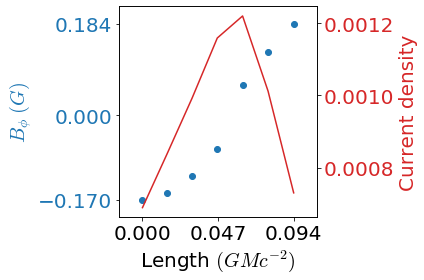

In [9]:
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_483_194_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_534_72_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_650_327_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_25_256_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_399_141_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_401_144_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_348_391_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_43_447_0_s"

#myfilename = "/home/gustavo/work/gyst/sheets/dump400_75_437_0_s"
myfilename = "/home/gustavo/work/gyst/sheets/dump400_23_257_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_557_64_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_234_263_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_386_310_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_256_226_0_s"
#myfilename = "/home/gustavo/work/gyst/sheets/dump400_396_74_0_s"

#myfilename = "/home/gustavo/work/gyst/sheets/dump400_465_67_0_s"

#myfilename = "/home/gustavo/work/gyst/sheets/dump400_265_205_0_s"


#myfilename = "/home/gustavo/work/gyst/sheets/dump400_287_279_0_s"
myfilename = "/home/gustavo/work/gyst/sheets/dump400_487_416_0_s"
#icenter, jcenter = 287,279
#icenter,jcenter=465,67
#icenter, jcenter = 386,310
#icenter, jcenter = 396,74
#icenter, jcenter = 23,257
icenter, jcenter = 487,416


myfile = open(myfilename, "r")

#headerline = myfile.readline()
#header = headerline.split()
#nheadertot = len(header)
#myfile.close()
                
#myBr = float(header[0])
#myBth = float(header[1])
#myBphi = float(header[2])
#mybeta = float(header[3])
#mysigma = float(header[4])
                
mydata = pd.read_csv(myfilename, sep='\t', header=0)
tabledata = mydata
mydata = mydata.values
mydata = np.transpose(mydata)

                
myBr       = mydata[0]
myBth      = mydata[1]
myBphi     = mydata[2]
myJ        = mydata[3]
mybeta     = mydata[4]
mysigma    = mydata[5]
mysigmaphi = mydata[6]
myi        = mydata[7]
myj        = mydata[8]
                
myfile.close()

position = []
for ii in range(len(myBr)):
    if ii == 0:
        distance = 0
        distanceold = 0
    else:
        r1 = r[ii][0][0]
        r2 = r[ii+1][0][0]
        th1 = h[0][ii][0]
        th2 = h[0][ii+1][0]
        distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
        distanceold = distance
    position.append(distance)
position = np.array(position)
    
xmin = round(min(position), 3)
xmax = round(max(position), 3)
xmid = round((xmax-xmin)/2, 3)
xmmin = round((xmid-xmin)/2, 3)
xmmax = round(xmax-xmid/2, 3)
#xticks = [xmin,xmmin,xmid,xmmax,xmax]
xticks = [xmin,xmid,xmax]

ymin1 = round(min(myBphi)*B_unit, 3)
ymax1 = round(max(myBphi)*B_unit, 3)
ymid1 = round(0.5*(ymax1+ymin1), 3)
yticks = [ymin1,0,ymax1]

fig, ax1 = plt.subplots()
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
color = 'tab:blue'
ax1.set_xlabel(r'Length $(GMc^{-2})$')
ax1.set_xticks(xticks)
ax1.set_ylabel(r'$B_\phi\;(G)$', color=color)
ax1.set_yticks(yticks)
ax1.scatter(position, myBphi*B_unit, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
ax2.plot(position, myJ, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("/home/gustavo/work/gyst/images/dump400_%d_%d_%d_p.png" %(i, j, k), dpi = 50)
#plt.savefig("/home/gustavo/work/gyst/dump400_%d_%d_%d_p.png" %(icenter, jcenter, 0), dpi = 150)
plt.show()
#plt.close()


In [119]:
max(myBphi)*B_unit

0.9029825305942881

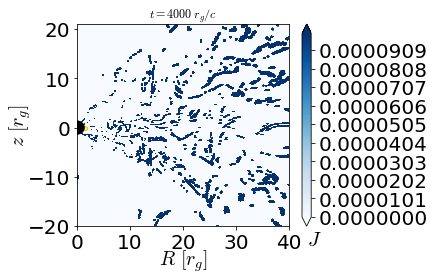

In [17]:
icoord = myi.tolist()
jcoord = myj.tolist()

#icenter, jcenter = 401,144
#icenter, jcenter = 75,437
#icenter, jcenter = 43,447
#icenter, jcenter = 27,255


rcenter = r[icenter][jcenter][0] * np.sin(h[icenter][jcenter][0])
hcenter = r[icenter][jcenter][0] * np.cos(h[icenter][jcenter][0])

icoord = [ int(element) for element in icoord]
jcoord = [ int(element) for element in jcoord]

rxx = []
ryy = []

for i in range(len(icoord)):
    rxx.append(r[icoord[i]][jcoord[i]][0] * np.sin(h[icoord[i]][jcoord[i]][0]))
    ryy.append(r[icoord[i]][jcoord[i]][0] * np.cos(h[icoord[i]][jcoord[i]][0]))


mirror = 1
if(mirror):
    xmax = 40
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 12
    xmax = 14
    ymin = -8
    ymax = -6
    step = 0.5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

#cs, cb = plco(Bphi, levels = np.linspace(-1, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 5)#, markersize = 0.01)
plt.scatter(rcenter, hcenter, c ='yellow', marker = 'o', s = 7)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

harm_script2.py:917: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(-ymax,ymax)


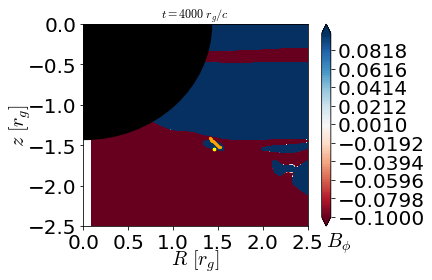

In [29]:
icoord = myi.tolist()
jcoord = myj.tolist()

#icenter, jcenter = 401,144
icenter, jcenter = 75,437
#icenter, jcenter = 43,447

#icenter, jcenter = 23,257
#icenter, jcenter = 396,74

rcenter = r[icenter][jcenter][0] * np.sin(h[icenter][jcenter][0])
hcenter = r[icenter][jcenter][0] * np.cos(h[icenter][jcenter][0])

icoord = [ int(element) for element in icoord]
jcoord = [ int(element) for element in jcoord]

rxx = []
ryy = []

for i in range(len(icoord)):
    rxx.append(r[icoord[i]][jcoord[i]][0] * np.sin(h[icoord[i]][jcoord[i]][0]))
    ryy.append(r[icoord[i]][jcoord[i]][0] * np.cos(h[icoord[i]][jcoord[i]][0]))


mirror = 0
if(mirror):
    xmax = 10
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 2.5
    ymin = -2.5
    ymax = 0
    step = 0.5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

cs, cb = plco(Bphi, levels = np.linspace(-0.1, 0.1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 5)#, markersize = 0.01)
plt.scatter(rcenter, hcenter, c ='yellow', marker = 'o', s = 7)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

In [133]:
sigmaext = []
betaext = []
BrBphiext = []
BthBphiext = []
                

#imin = 800
#imax = imin+400
for i in range(0,N1):
    for j in range(0,N2):
        for k in range(0,N3):
            myfilename = "/home/gustavo/work/gyst/sheets/dump400_%d_%d_%d_s" %(i,j,k)
            if (os.path.isfile(myfilename)):
                #print(i, j, k)
                
                myfile = open(myfilename, "r")
                mydata = pd.read_csv(myfilename, sep='\t', header=0)
                tabledata = mydata
                mydata = mydata.values
                mydata = np.transpose(mydata)
                myBr       = mydata[0]
                myBth      = mydata[1]
                myBphi     = mydata[2]
                myJ        = mydata[3]
                mybeta     = mydata[4]
                mysigma    = mydata[5]
                mysigmaphi = mydata[6]
                myi        = mydata[7]
                myj        = mydata[8]
                myfile.close()
                
                sigmaext.append(mysigma[0])
                sigmaext.append(mysigma[-1])
                betaext.append(mybeta[0])
                betaext.append(mybeta[-1])
                
                BrBphiext.append(abs(B[1][i][j][k]/B[3][i][j][k]))
                BthBphiext.append(abs(B[2][i][j][k]/B[3][i][j][k]))

In [134]:
BrBphiext = [x for x in BrBphiext if str(x) != 'nan']
BrBphiext = [x for x in BrBphiext if str(x) != 'inf']

BthBphiext = [x for x in BthBphiext if str(x) != 'nan']
BthBphiext = [x for x in BthBphiext if str(x) != 'inf']

betaext = [x for x in betaext if str(x) != 'nan']
betaext = [x for x in betaext if str(x) != 'inf']

sigmaext = [x for x in sigmaext if str(x) != 'nan']
sigmaext = [x for x in sigmaext if str(x) != 'inf']

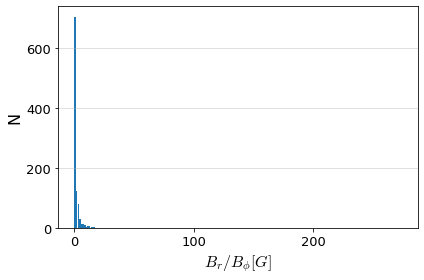

In [162]:
histmin = ((array(BrBphiext)).min()).astype(int)
histmax = ((array(BrBphiext)).max()).astype(int)

plt.hist(BrBphiext, bins=200, rwidth=0.9, range=[histmin,histmax]) # arguments are passed to np.histogram
#astropy.visualization.hist(BthBrext, bins=200, rwidth=0.9)#, range=[histmin,histmax])
#plt.axvline(z.mean(), color='k', linestyle='dashed', linewidth=2)
#plt.axvline(np.median(z), color='k', linestyle='dashed', linewidth=2)

_, max_ = plt.ylim()
#plt.text(z.mean() + z.mean()/15, max_ - max_/10, 'Mean: {:.2f}'.format(z.mean()), fontsize=12)
#plt.text(np.median(z) + np.median(z)/15, max_ - max_/10, 'Median: {:.2f}'.format(np.median(z)), fontsize=12)

#plt.title("Redshifts of FSRQs", fontsize=18)
plt.xlabel(r"$B_r/B_\phi [G]$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("BrBphi.png", dpi=300)

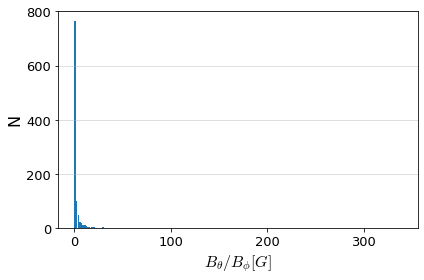

In [163]:
histmin = ((array(BthBphiext)).min()).astype(int)
histmax = ((array(BthBphiext)).max()).astype(int)

plt.hist(BthBphiext, bins=200, rwidth=0.9, range=[histmin,histmax]) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_\theta/B_\phi [G]$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig("BthBphi.png", dpi=300)

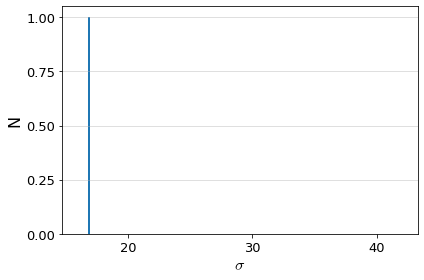

In [117]:
histmin = ((array(sigmaext)).min()).astype(int)
histmax = ((array(sigmaext)).max()).astype(int)

plt.hist(sigmaext, bins=200, rwidth=0.9, range=[histmin,histmax]) # arguments are passed to np.histogram
#astropy.visualization.hist(BthBrext, bins=200, rwidth=0.9)#, range=[histmin,histmax])
#plt.axvline(z.mean(), color='k', linestyle='dashed', linewidth=2)
#plt.axvline(np.median(z), color='k', linestyle='dashed', linewidth=2)

_, max_ = plt.ylim()
#plt.text(z.mean() + z.mean()/15, max_ - max_/10, 'Mean: {:.2f}'.format(z.mean()), fontsize=12)
#plt.text(np.median(z) + np.median(z)/15, max_ - max_/10, 'Median: {:.2f}'.format(np.median(z)), fontsize=12)

#plt.title("Redshifts of FSRQs", fontsize=18)
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("z_hist.png", dpi=300)

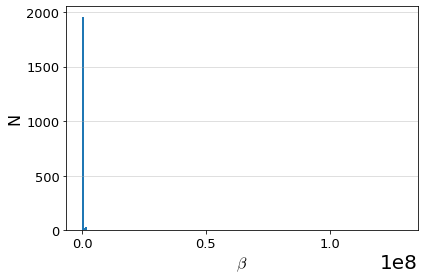

In [118]:
histmin = ((array(betaext)).min()).astype(int)
histmax = ((array(betaext)).max()).astype(int)

plt.hist(betaext, bins=200, rwidth=0.9, range=[histmin,histmax]) # arguments are passed to np.histogram
#astropy.visualization.hist(BthBrext, bins=200, rwidth=0.9)#, range=[histmin,histmax])
#plt.axvline(z.mean(), color='k', linestyle='dashed', linewidth=2)
#plt.axvline(np.median(z), color='k', linestyle='dashed', linewidth=2)

_, max_ = plt.ylim()
#plt.text(z.mean() + z.mean()/15, max_ - max_/10, 'Mean: {:.2f}'.format(z.mean()), fontsize=12)
#plt.text(np.median(z) + np.median(z)/15, max_ - max_/10, 'Median: {:.2f}'.format(np.median(z)), fontsize=12)

#plt.title("Redshifts of FSRQs", fontsize=18)
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#plt.savefig("z_hist.png", dpi=300)

In [27]:
myfilename = "/home/gustavo/work/gyst/sheets/dump400_23_257_0_s"
myfile = open(myfilename, "rb")
dtype = np.float64
body = np.fromfile(myfile,dtype=dtype,count=-1)
sheetrows = (body.size)/9
mydata = body.view().reshape((int(9),int(sheetrows)), order='F')

myBr       = mydata[0]
myBth      = mydata[1]
myBphi     = mydata[2]
myJ        = mydata[3]
mybeta     = mydata[4]
mysigma    = mydata[5]
mysigmaphi = mydata[6]
myi        = mydata[7]
myj        = mydata[8]

In [29]:
myBphi

array([-0.34828204, -0.27294275, -0.01258251, -0.1885142 , -0.10057796,
       -0.01043897,  0.07622349,  0.15421097,  0.22113188,  0.27414528,
        0.31577325,  0.34334722,  0.3603611 ,  0.36929286])